- competition/dataset : [https://www.kaggle.com/c/mercari-price-suggestion-challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge)
- date : 2021/03/15
- original : [https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling](https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling)

## Mercari Interactive EDA + Topic Modelling

**✏ 필사 1회** 

### Introduction
이 대회는 일본의 가장 큰 커뮤니티 기반 쇼핑 앱인 Mercari에 의해 개최되었으며, 주요 목표는 주어진 아이템의 정보로 Mercali가 셀러에게 제시해야 할 정확한 가격을 에측하는 것입니다.  

이 커널의 프레임워크는 Ahmed BESBES의 소스 코드를 기반으로 합니다. 문서 전처리와 클러스터링 주제에 대한 머신러닝 기술(K-means, LDA)에 대한 지침을 제공합니다. 해당 커널은 크게 두 부분으로 나뉩니다:  
1. Exploratory Data Analysis  
2. Text Preprocessing
    2-1. Tokenizing and tf-idf algorithm  
    2-2. K-means Clusturing  
    2-3. Latent Dirichlet Allocation (LDA)  

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep='\t')

In [4]:
# 데이터셋의 크기
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [5]:
# 데이터셋의 타입 확인
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [9]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


### Target Variable: **Price**
다음 표준적인 검사는 반응 변수 혹은 목표 변수이며, 여기서는 Mercari 시장 셀러에게 제안할 `price`가 목표 변수입니다. 모든 아이템의 중간 가격은 26.7달러 정도이지만 주어진 일부 극단값은 100달러가 넘고 최댓값은 2009달러로, 변수의 분포가 왼쪽으로 크게 치우쳐져 있습니다. 따라서 가격에 로그 변환을 취하겠습니다. (0이나 음수 값을 대비해 1을 더하여 변환할 것입니다.)

In [10]:
train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

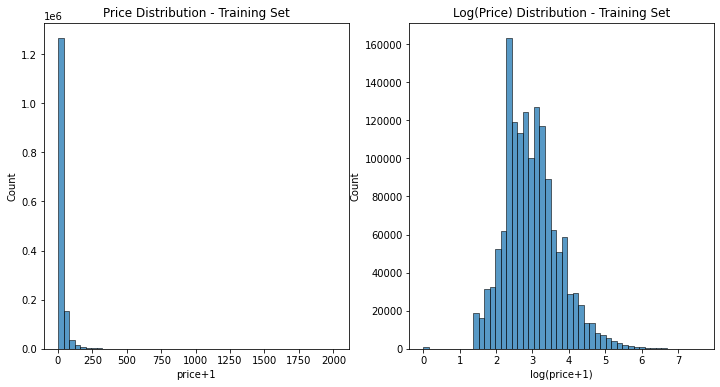

In [28]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(train['price'] + 1, bins=50, ax=ax[0])
ax[0].set_xlabel('price+1')
ax[0].set_title('Price Distribution - Training Set')
sns.histplot(np.log(train['price'] + 1), bins=50, ax=ax[1])
ax[1].set_xlabel('log(price+1)')
ax[1].set_title('Log(Price) Distribution - Training Set')
plt.show()

### Shipping
운송비는 판매자(55%)와 구매자(45%)가 적절히 나눠서 부담합니다. 또한 운송비를 부담해야 하는 유저가 지불한 평균 금액은 부가적인 운송비가 요구되지 않은 유저들에 비해 낮습니다. 이것은 판매자들이 추가 배송비를 보상하기 위해 낮은 가격이 필요하다는 우리의 인식과 일치합니다.

In [31]:
train['shipping'].value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

### Item Category


카테고리는 총 1,287개가 있으나, 우리는 main/general 카테고리를 먼저 보고, 두 개의 특정 하위 카테고리를 추가로 확인할 것입니다. 추가로 카테고리 레이블이 없는 6,327개의 상품이 있습니다. 카테고리를 크게 세 가지 컬럼으로 나눠봅시다. 이 정보가 실제로 판매자의 관점에서 중요하며, `brand_name` 컬럼의 결측값을 처리하는 것이 모델의 에측에 영향을 준다는 것을 알게 될 것입니다.

In [51]:
# 카테고리 개수
print('There are {} unique values in the category column'.format(train['category_name'].nunique()))

There are 1287 unique values in the category column


In [39]:
# 카테고리 상위 5개
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [44]:
# 카테고리가 없는 상품 수
(train['category_name'].isnull() == True).sum()

6327

In [45]:
# 카테고리 분할
def split_cat(text):
    try:
        return text.split('/')
    except:
        return ('No Label', 'No Label', 'No Label')

In [50]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse


In [54]:
print('There are %d unique main categories.'%train['general_cat'].nunique())

There are 11 unique main categories.


In [52]:
print('There are %d unique first sub-categories.'%train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [53]:
print('There are %d unique second sub-categories.'%train['subcat_2'].nunique())

There are 871 unique second sub-categories.


11개의 주 카테고리와 114개의 첫 번째 서브 카테고리, 871개의 두 번째 서브 카테고리가 있습니다.

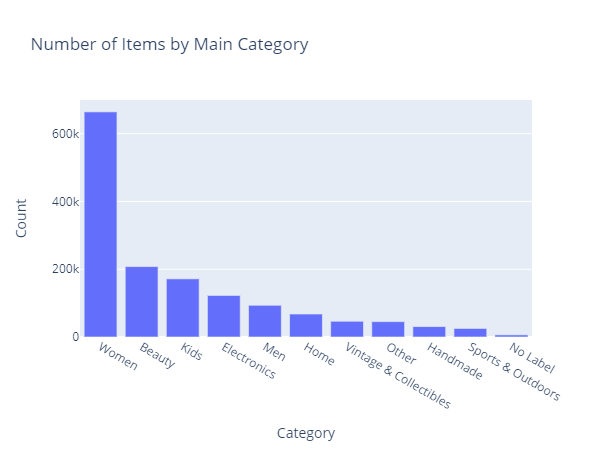

In [73]:
x = train['general_cat'].value_counts().index.values
y = train['general_cat'].value_counts().values
pct = [('%.2f'%(v*100)) + '%' for v in (y/len(train))]

data = [go.Bar(x=x, y=y, text=pct)]
layout = dict(title='Number of Items by Main Category',
              yaxis=dict(title='Count'),
              xaxis=dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

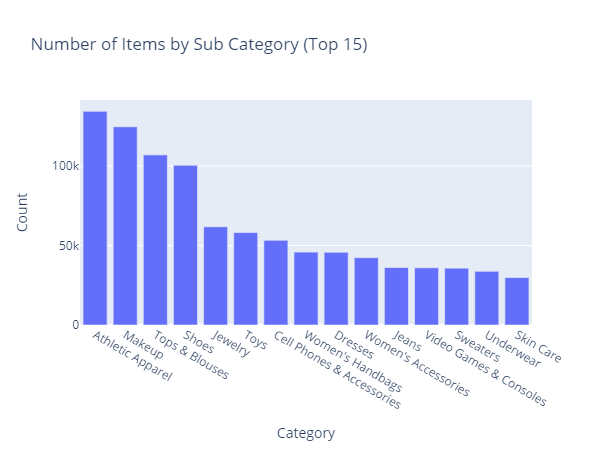

In [74]:
x = train['subcat_1'].value_counts().index.values[:15]
y = train['subcat_1'].value_counts().values
pct = [('%.2f'%(v*100)) + '%' for v in (y/len(train))]

data = [go.Bar(x=x, y=y, text=pct)]
layout = dict(title='Number of Items by Sub Category (Top 15)',
              yaxis=dict(title='Count'),
              xaxis=dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

### Brand Name

In [75]:
print('There are %d unique brand names in the training dataset.'%train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


### Item Description
이것은 비정형 데이터이기 때문에 구문을 분석하기가 더 어려울 것입니다. 자세하고 길이가 길수록 입찰 가격이 높을까요? 모든 문장 부호를 잘라내고, 불용어와 3 미만의 길이인 단어들을 제거하겠습니다.

In [102]:
def wordCount(text):
    try:
        text = text.lower()
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(' ', text)
        words = [w for w in txt.split(' ') if not w in stop_words and len(w) > 3]
        return len(words)
    except:
        return 0

In [93]:
train['item_description'][1].lower()
re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]').sub(' ', train['item_description'][1].lower()).split(' ')

['this',
 'keyboard',
 'is',
 'in',
 'great',
 'condition',
 'and',
 'works',
 'like',
 'it',
 'came',
 'out',
 'of',
 'the',
 'box',
 '',
 'all',
 'of',
 'the',
 'ports',
 'are',
 'tested',
 'and',
 'work',
 'perfectly',
 '',
 'the',
 'lights',
 'are',
 'customizable',
 'via',
 'the',
 'razer',
 'synapse',
 'app',
 'on',
 'your',
 'pc',
 '']

In [103]:
# 단어 수 컬럼 추가
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [104]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,10


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   desc_len  139 non-null    int64  
 1   price     139 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.3 KB


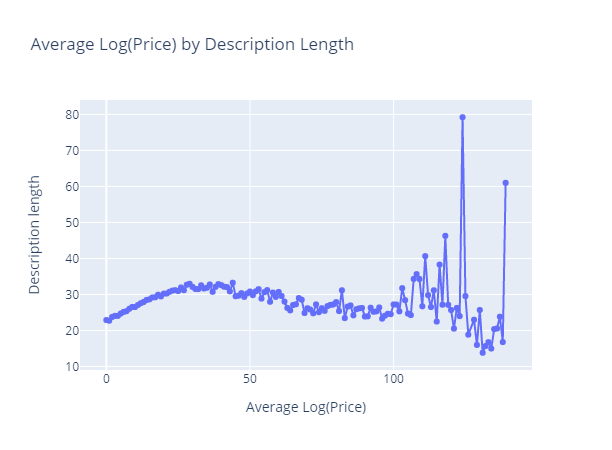

In [114]:
df = train.groupby('desc_len')['price'].mean().reset_index()

data = [go.Scatter(x=df['desc_len'], y=df['price'], mode='lines+markers',)]
layout = dict(title='Average Log(Price) by Description Length',
              yaxis=dict(title='Description length'),
              xaxis=dict(title='Average Log(Price)'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

item descriptino에 결측값이 있는지도 반드시 확인하고, 있다면 제거해야 합니다.

In [ ]:
train = train[pd.notnull(train['item_description'])]

### Text Processing - Item Description